# Machine Learning Unsupervised Clustering
# k-mean e GMM: algoritmi a confronto

#### Alessandro Cucci - Python Expertise Manager @ Energee3 srl <alessandro.cucci@energee3.com> 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from utils import plot_gmm, plot_kmeans, draw_ellipse

Parlando di algoritmi di **Machine Learning**, questi vengono principalmente suddivisi in due grandi famiglie: _**apprendimento supervisionato**_ e _**apprendimento non supervisionato**_. 
Il primo passo per la soluzione di un problema è capire se il modello che andremo ad implementare utilizzerà degli algoritmi di apprendimento automatico facenti parte del primo gruppo o del secondo (anche non di rado potrebbero volerci entrambi). Per farlo, occorrerà studiare il set di dati che ci viene fornito, che di solito si compone di una serie di caratteristiche (features) e, opzionalmente, una lista di output. 

Per rendere le cose semplici, possiamo dire che se nel nostro dataset sono presenti delle variabili di output dovremo orientarci su uno o più algoritmi di apprendimento supervisionato, altrimenti la strada da percorrere sarà quella dell'apprendimento non supervisionato. 

Facciamo un paio di esempi: 
1. Dallo storico dei dati di vendita di un negozio vorrei predire le vendite nel prossimo mese. Questo è un esempio di apprendimento supervisionato;
2. Dato un grande database di clienti (con il loro relativo storico di acquisti) vorrei definire dei gruppi in base a comportamenti di acquisto simili. Non conoscendo a priori queste proprietà comportamentali, utilizzerò degli algoritmi di apprendimento non supervisionato.

Tra gli algoritmi di apprendimento non supervisionato, quelli più comuni sono gli **algoritmi di clustering**, usati appunto per raggruppare i dati in varie classi distinte. I due algoritmi principali usati per questo scopo sono: **K-Means** e i **Gaussian Mixture Models** (GMM).

## Dataset
### Genero un dataset di blobs randomici

Lo script che segue genera un grafico con dei punti (800) sparsi in modo casuale. 
Per le nostre elaborazioni, ipotizziamo di dividere il nostro dataset in _quattro cluster distinti_.
La funzione _make_blobs_ prende come input il numero di oggetti che vogliamo generare e il numero di cluster su cui dividerli (n_samples e centers). Come output, ci fornirá X, un array bidimensionale (ogni elemento rappresenta le coordinate x e y dell' oggetto generato casualmente in modo da poterlo disegnare come punto su un piano cartesiano), e un array monodimensionale y_true con il numero del cluster al quale appartiene quell' oggetto.
NB. Il parametro _random_state_ serve semplicemente a impostare un seme per l'algoritmo casuale, in modo da rendere questa elaborazione riproducibile.

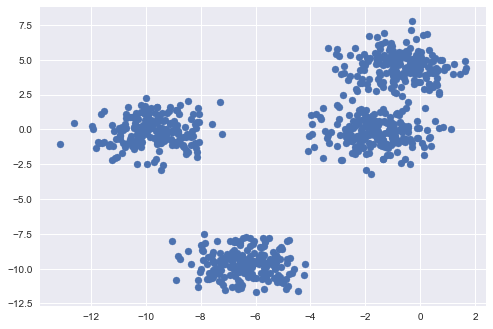

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=800, centers=4, random_state=11)
plt.scatter(X[:, 0], X[:, 1]);

## K-means

Il primo algoritmo di clustering non supervisionato che andremo ad analizzare si chiama K-Means. Il suo compito è quello di assegnare a ogni oggetto di un set di dati multidimensionale (bidimensionale in questo caso) il suo cluster di appartenenza (sapendo a priori il numero di cluster su cui dividere i dati). Per farlo, utilizza i seguenti concetti:
1) il _centroide_ é la media aritmetica tra tutti gli oggetti facenti parte di quel cluster
2) un oggetto facente parte di un cluster é piú vicino al centroide di quel cluster rispetto a tutti gli altri centroidi.

Usando la tipica API di predizione di _scikit-learn_, lasceremo all'algoritmo il compito di trovare il centro di ogni cluster e di conseguenza assegnare ogni punto al cluster con il centroide piú vicino. 

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

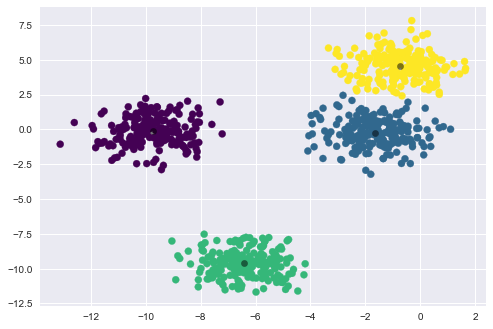

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=40, alpha=0.5);

Questo é l'algoritmo su cui si basa k-mean:

- Imposta randomicamente i centri dei cluster
- _Ripete_ fino alla convergenza:
    - assegna i punti al cluster con il centroide piú vicino
    - ricalcola i centri dei cluster usando la media dei punti di ogni cluster 

Spesso, a ogni iterazione dell'algoritmo, il risultato sará una sempre migliore stima delle caratteristiche del cluster.

## Gaussian Mixture Models

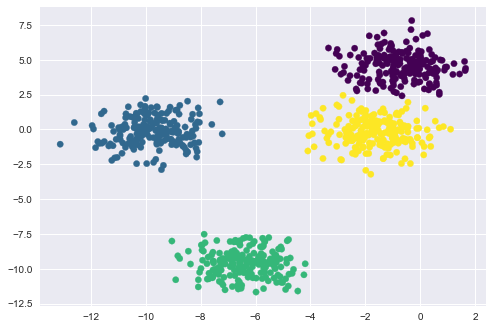

In [5]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Sotto il cofano, ecco cosa fa questo algoritmo:
- Inizia stimando le posizioni e le forme dei cluster
- Ripete fino alla convergenza:
    - per ogni punto, trova i pesi salvandosi la probabilità che ogni punto appartenga a un certo cluster per tutti i cluster
    - per ogni cluster, aggiorna la posizione, normalizzazione e forma geometrica basandosi sul peso di tutti i punti

Visto che la clusterizzazione degli oggetti funziona bene anche con questo, proviamo a confrontare in dettaglio i due algoritmi:

## Comparazione dei due algoritmi di clustering

## Performance

Generalmente, per grossi dataset, è conveniente utilizzare k-means per l'elaborazione dei cluster. Questo perchè è più semplice e fa meno assunzioni (come vedremo a breve nelle prossime sezioni). 

Ecco le performance dei due algoritmi utilizzando il dataset che abbiamo generato (e qui parliamo di pochi centinaia di punti, la differenza si fa molto più netta con il crescere di questi).
Partiamo da k-means:

In [6]:
%timeit -n 1 -r 1 kmeans.predict(X)

1 loop, best of 1: 604 µs per loop


Il tempo di esecuzione della clasterizzazione di GMM è invece:

In [7]:
%timeit -n 1 -r 1 gmm.predict(X)

1 loop, best of 1: 849 µs per loop


## Geometria dei Dati

Uno dei motivi per cui GMM impiega più tempo ad elaborare i dati è perchè, a differenza di k-mean, fa qualche considerazione in piú. In questa sezione cercheremo di capire quando è obbligatorio usare GMM per non rischiare di creare dei cluster sbagliati dal nostro dataset, anche se ciò dovesse implicare un maggior tempo di elaborazione.

A volte, quando guardiamo la rappresentazione di un dataset con i nostri occhi (umani), il cervello riesce a capire con esattezza quali punti appartengano a un dato cluster piuttosto che a un altro, mentre in alcuni casi potremmo avere un grado più o meno alto di incertezza. K-means non conosce questo significato, lui ragiona così: immaginate di disegnare un cerchio avente come centro il centroide del cluster e come raggio la distanza tra il centroide e l'oggetto piú lontano di quel cluster. Per k-mean, ogni oggetto al di fuori di questo cerchio, non fa parte del cluster.

Facciamo un esempio grafico:

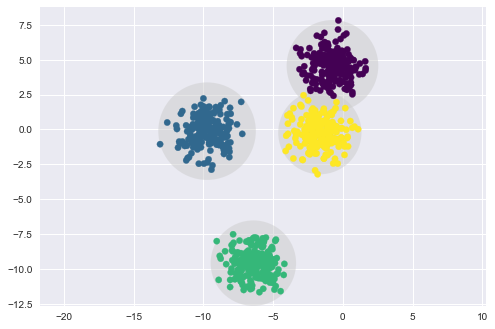

In [8]:
plot_kmeans(kmeans, X)

Questo approccio non funziona su un set di dati fatto per esempio cosí:

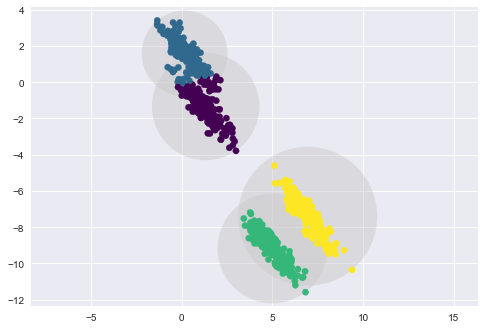

In [9]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=1)
plot_kmeans(kmeans, X_stretched)

In questo caso, piú che un raggruppamento di forma sferica, ci saremmo aspettatti un raggruppamento su forma ellittica. Guardiamo la differenza con la seguente elaborazione di GMM:

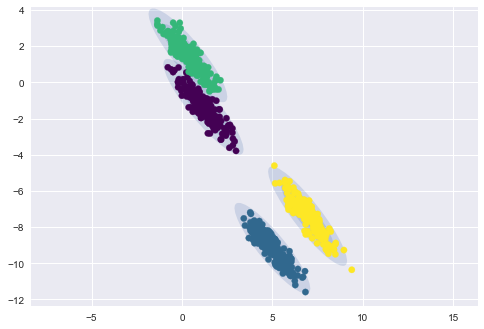

In [10]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)        
plot_gmm(gmm, X_stretched)

N.B. Questa volta abbiamo passato un parametro aggiuntivo a gmm: _covariance_type_. Questo parametro è una stringa di testo che rappresenta i gradi di libertà della forma di ogni cluster. Quelli più usati da GMM sono:
1. *diag (default)*: vengono usati gli assi per allineare le ellissi, ma le dimensioni sono settate liberamente
2. *spherical*: la forma di queste ellissi si avvicina molto a una forma circolare. Il risultato è simile a quello fornito da k-mean, anche se non identico
3. *full*: massimo grado di libertà per costruire la forma dei cluster (ma ha un maggior dispendio computazionale).

Ecco la differenza tra le tre:

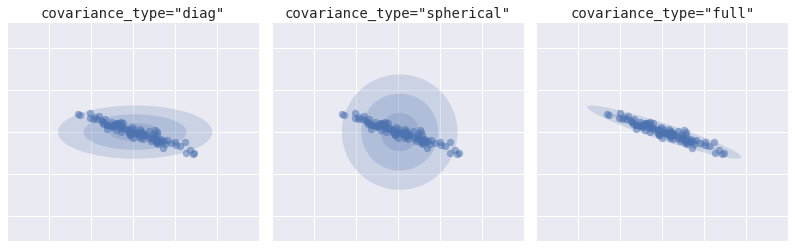

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)

rng = np.random.RandomState(8)
X = np.dot(rng.randn(100, 2), rng.randn(2, 2))

for i, cov_type in enumerate(['diag', 'spherical', 'full']):
    model = GaussianMixture(1, covariance_type=cov_type).fit(X)
    ax[i].axis('equal')
    ax[i].scatter(X[:, 0], X[:, 1], alpha=0.5)
    ax[i].set_xlim(-3, 3)
    ax[i].set_title('covariance_type="{0}"'.format(cov_type),
                    size=14, family='monospace')
    draw_ellipse(model.means_[0], model.covariances_[0], ax[i], alpha=0.2)
    ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].yaxis.set_major_formatter(plt.NullFormatter())

## Conclusioni

### K-mean

- *Vantaggi*
    1. Tempo di elaborazione
    2. E' maggiormente indicato per dati multidimensionali.
    3. Facile da interpretare e implementare.
    
    
- *Svantaggi*
    1. Assume che la forma dei cluster sia sferica, quindi non funziona bene con dati dalla forma geometrica complessa.
    2. Evitare di considerare le incertezze nell'assegnazione di un punto a un cluster potrebbe portare a errori di valutazione e assegnazione.
    

### Gaussian Mixture Models

- *Vantaggi*
    1. Lavora bene su dati che hanno distribuzione geometrica non lineare. Non parte dall'assunzione che i cluster abbiano per forza una forma circolare. 
    
    
- *Svantaggi*
    1. L'inizializzazione dei cluster è più complessa quanto più è alta la dimensionalità dei dati
    2. A volte è difficile da interpretare.